In [5]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#16a085', '#e8f6f3', '#d0ece7', '#a2d9ce', '#73c6b6', '#45b39d', 
                        '#16a085', '#138d75', '#117a65', '#0e6655', '#0b5345']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = ''' 

div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s; /* light orange */
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s; /* light orange */
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
    border-top: 2px solid %s; /* light orange */
}

div.input_prompt {
color: %s; /* light blue */
}

div.output_prompt {
color: %s; /* strong orange */
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s; /* light orange */
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s; /* light orange */
}

.edit_mode div.cell.selected:before {
background: %s; /* light orange */
}

.edit_mode div.cell.selected {
border-color: %s; /* light orange */

}
'''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

### Do not forget to put upvote for the notebook, follow me on Kaggle and the ⭐️ for github repo if you like it - one click for you, great pleasure for us ☺️ 
### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [6]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [7]:
%%capture
!pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [67]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [10]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900 # equal to 15 minutes
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [11]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [12]:
INPUT_DIR = '../input/sf-dst-predict-car-price/'

In [13]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.00
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.00
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.00
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.00
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.00


In [14]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [15]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()


(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### Step 0.5. Some user feature preparation

Be creative :)

In [16]:
def get_top_unique_values(df, level=0):
    """
    Function for getting information on unique values in attributes
    :param df: Dataframe for analysis
    :param level: Uniqueness level in %, signs below this level are not output
    ::return: Returns a dataframe with the name of the attribute, the number of unique values, the most frequently repeated
        a unique value, how much % of the sample this value takes, the number of repetitions
    """

    cols = list(df.columns)

    # создаём пустой список
    unique_list = []

    for col in cols:
        col_lev = round(df[col].value_counts(normalize=True).values[0] * 100, 2)

        if col_lev > level:
            item = (col, df[col].nunique(), df[col].value_counts(normalize=True).index[0], col_lev,
                    df[col].value_counts().values[0])
            # добавляем кортеж в список
            unique_list.append(item)

    unique_values = pd.DataFrame(
        unique_list,
        columns=['Column Name', 'Count Unique', 'Top Value', 'Top Value %', 'Top Value Count']
    )

    return unique_values

In [17]:
def outliers_iqr(df, feature, log_scale=False, left=1.5, right=1.5):
    """
    Function for determining emissions by the Tukey method.
        :param df: Source dataframe
    :param feature: Fitch dataframe to determine outliers
    ::param log_scale: Do I need to logarithm the feature
    in question ::paramleft: Multiplier to determine the left edge of the outlier, by default 1.5
    :param right: Multiplier to determine the right edge of the outlier, by default 1.5
    :return: The function returns a dataframe with emissions-free and emission-free dataframe
    """

    x = df[feature]

    if log_scale:
        x = np.log(x)

    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1

    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)

    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) & (x < upper_bound)]
    info = f'Выбросы: {outliers.shape[0]} строк ({outliers.shape[0] / df.shape[0] * 100:.2f}%).'

    return info, outliers, cleaned

In [18]:
def Hist_and_Box_Plots(df, column_name, bins=30):
    """
    A function for plotting a distribution diagram and a box with a mustache
    to assess the normality of the distribution and search for outliers
    :param df: Source dataframe
    :param column_name: Attribute name for analysis
    ::param bind: Default number of groups 30
    :return: Displays a graph
    """

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    axes[0].ticklabel_format(style='plain', axis='x')
    histplot = sns.histplot(data=df, x=column_name, bins=bins, ax=axes[0])

    histplot.set_title(f'{column_name} Histogram')
    axes[1].ticklabel_format(style='plain', axis='x')
    boxplot = sns.boxplot(data=df, x=column_name, ax=axes[1])
    boxplot.set_title(f'{column_name} Boxplot')

    plt.tight_layout()
    plt.show()

In [19]:
get_top_unique_values(train_data)

,Column Name,Count Unique,Top Value,Top Value %,Top Value Count
0,vehicle_manufacturer,68,TOYOTA,19.34,6768
1,vehicle_model,2224,Prius,6.72,2350
2,vehicle_category,11,Sedan,44.24,15483
3,current_mileage,11273,0,4.01,1403
4,vehicle_year,68,2012,11.20,3919
5,vehicle_gearbox_type,4,Automatic,69.40,24290
6,doors_cnt,3,4/5,94.72,32446
7,wheels,2,Left wheel,92.02,32207
8,vehicle_color,16,Black,26.17,9053
9,vehicle_interior_color,11,Black,74.55,21083


In [20]:
# feature deal_type
# I will look at the median price and mileage in the context of the type of transaction
# I see a strong bias in the median price. These are generally two logically different events, buying and renting a car.
# # In addition, the number of rental records is a very small proportion of the total sample
train_data.groupby('deal_type').agg({'deal_type': 'count', 'final_price': 'median', 'current_mileage': 'median'})

,deal_type,final_price,current_mileage
deal_type,,,
For Rent,628,16.00,126000.00
For Sale,34372,4000.00,129000.00


In [21]:
# I'll only look at rental cars
only_rent = train_data[train_data['deal_type'] == 'For Rent']
only_rent

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
97,97,HONDA,FIT,Hatchback,65000,2007,Automatic,4/5,Right-hand drive,Silver,Grey,NaN,0,For Rent,14.00
128,128,TOYOTA,Prius,Hatchback,100000,2008,Automatic,4/5,Left wheel,Grey,Grey,NaN,0,For Rent,16.00
138,138,TOYOTA,Highlander limited,Sedan,120000,2008,Variator,4/5,Left wheel,Silver,Grey,NaN,1,For Rent,32.00
163,163,HYUNDAI,Elantra,Sedan,64000,2015,Tiptronic,4/5,Left wheel,Silver,Grey,NaN,0,For Rent,22.00
208,208,FORD,Focus,Hatchback,100000,2012,Automatic,4/5,Left wheel,White,Black,NaN,1,For Rent,22.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34623,34623,BMW,745,Sedan,145000,2004,Automatic,>5,Left wheel,White,Beige,NaN,1,For Rent,45.00
34793,34793,MERCEDES-BENZ,CLS 500,Sedan,100000,2008,Tiptronic,4/5,Left wheel,Black,Black,NaN,1,For Rent,48.00
34866,34866,HONDA,FIT,Hatchback,0,2003,Automatic,4/5,Right-hand drive,White,Grey,NaN,0,For Rent,10.00
34953,34953,MITSUBISHI,Pajero IO,Jeep,130000,2000,Automatic,4/5,Left wheel,Silver,Grey,NaN,0,For Rent,21.00


In [22]:
# The median price of $ 16 is quite logical for a day of rent, and min and max are inadequate
only_rent.describe()

,row_ID,current_mileage,vehicle_year,car_leather_interior,final_price
count,628.00,628.00,628.00,628.00,628.00
mean,17204.37,5353802.71,2007.61,0.33,233.33
std,10523.16,96416014.54,7.36,0.47,1370.95
min,97.00,0.00,1939.00,0.00,0.00
25%,7850.50,65000.00,2005.00,0.00,13.00
50%,17034.50,126000.00,2008.00,0.00,16.00
75%,26551.75,170000.00,2012.00,1.00,32.00
max,34986.00,2147483647.00,2020.00,1.00,19000.00


In [23]:
# I generally remove data on rental cars from the training sample
train_data = train_data[train_data['deal_type'] != 'For Rent']

In [24]:
# And in the test sample I save the indexes of all cars for rent
# # And at the very end of the submission I fill in manually with the median rental cost of $16.
rent_cars_index_list = list(test_data[test_data['deal_type'] == 'For Rent'].index)

In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34372 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  34372 non-null  int64  
 1   vehicle_manufacturer    34371 non-null  object 
 2   vehicle_model           34365 non-null  object 
 3   vehicle_category        34371 non-null  object 
 4   current_mileage         34372 non-null  int64  
 5   vehicle_year            34372 non-null  int64  
 6   vehicle_gearbox_type    34371 non-null  object 
 7   doors_cnt               33627 non-null  object 
 8   wheels                  34371 non-null  object 
 9   vehicle_color           33971 non-null  object 
 10  vehicle_interior_color  27654 non-null  object 
 11  car_vin                 11478 non-null  object 
 12  car_leather_interior    34372 non-null  int64  
 13  deal_type               34372 non-null  object 
 14  final_price             34372 non-null

In [26]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10696 non-null  object
 2   vehicle_model           10695 non-null  object
 3   vehicle_category        10696 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10696 non-null  object
 7   doors_cnt               10474 non-null  object
 8   wheels                  10696 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  8619 non-null   object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


In [27]:
# vehicle_year
train_data['vehicle_year'].describe()

count   34372.00
mean     2010.71
std        12.31
min         0.00
25%      2009.00
50%      2012.00
75%      2014.00
max      2020.00
Name: vehicle_year, dtype: float64

In [28]:
test_data['vehicle_year'].describe()

count   10697.00
mean     2010.56
std        20.30
min         0.00
25%      2008.00
50%      2012.00
75%      2014.00
max      2020.00
Name: vehicle_year, dtype: float64

In [29]:
# Year zero of the release? I'm looking at these records
train_data[train_data['vehicle_year'] == 0]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
17918,17918,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,For Sale,0.00


In [30]:
# By index, I delete this record from the training sample
ind = train_data[train_data['vehicle_year'] == 0].index
train_data.drop(ind, inplace=True)

In [31]:
test_data[test_data['vehicle_year'] == 0]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
2254,37254,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,For Sale


In [32]:
# These are completely empty entries. I delete the record from the training sample, it distorts the training.\
# And I can't delete anything from the test sample, so I keep the index. 
# # At the very end, I will replace the value with 0 on the final submision file filled with the model.
index_to_set_zero = test_data[test_data['vehicle_year'] == 0].index[0]
index_to_set_zero

2254

In [33]:
# feature vehicle_age
def vehicle_age_feature(data):
    data['vehicle_age'] = 2021 - data['vehicle_year'] # The competition was launched last year, I will take that year as a base
    data = data.drop(columns=['vehicle_year'], axis=1)
    return data

In [34]:
%%time
train_data = vehicle_age_feature(train_data)
test_data = vehicle_age_feature(test_data)

CPU times: user 14.2 ms, sys: 2.65 ms, total: 16.9 ms
Wall time: 16.4 ms


In [35]:
# feature current_mileage
# With zero mileage, well, like everything is OK, maybe just the car was new.
# But the mileage is unclear what 2_147_483_647. Two billion miles!
train_data['current_mileage'].describe()

count        34371.00
mean       1907440.59
std       55841409.92
min              0.00
25%          71499.00
50%         129000.00
75%         190555.50
max     2147483647.00
Name: current_mileage, dtype: float64

In [36]:
# I'll look at the mileage over 1 million miles
train_data[train_data['current_mileage'] > 1_000_000]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age
358,358,MERCEDES-BENZ,E 200,Sedan,2844468,Manual,4/5,Left wheel,Blue,Black,NaN,0,For Sale,3500.00,20
613,613,SUBARU,Legacy,Universal,1980000,Tiptronic,4/5,Right-hand drive,Black,Black,NaN,0,For Sale,2200.00,16
660,660,MITSUBISHI,Pajero,Jeep,1111111,Automatic,4/5,Left wheel,Golden,Brown,NaN,0,For Sale,2000.00,25
824,824,SUZUKI,Swift,Hatchback,23000000,Manual,4/5,Right-hand drive,Silver,Beige,NaN,0,For Sale,733.00,16
901,901,BMW,318,Sedan,1111111111,Manual,4/5,Left wheel,Black,Black,NaN,1,For Sale,957.00,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34052,34052,MERCEDES-BENZ,ML 320,Jeep,111111111,Tiptronic,4/5,Left wheel,White,Black,NaN,1,For Sale,6666666.00,19
34230,34230,OPEL,Astra,Sedan,111111111,Manual,4/5,Left wheel,Silver,White,NaN,0,For Sale,1700.00,22
34360,34360,FORD,Transit,Microbus,1111111,Manual,2/3,Left wheel,White,Grey,NaN,0,For Sale,4100.00,21
34791,34791,MERCEDES-BENZ,200,Sedan,3000000,Manual,4/5,Left wheel,Green,Black,NaN,0,For Sale,2000.00,23


In [37]:
test_data[test_data['current_mileage'] > 1_000_000]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,vehicle_age
153,35153,RENAULT,Kangoo,Universal,584697469,Manual,4/5,Left wheel,Silver,Grey,NaN,0,For Sale,18
162,35162,MERCEDES-BENZ,S 500,Sedan,2600000,Tiptronic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,19
224,35224,MERCEDES-BENZ,CLS 500,Sedan,2147483647,Tiptronic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,15
269,35269,VAZ,2121 (Niva),Jeep,10000000,Manual,4/5,Left wheel,White,Black,NaN,0,For Sale,21
525,35525,BMW,525,Sedan,7777787,Manual,4/5,Left wheel,Silver,Grey,NaN,1,For Sale,18
737,35737,OPEL,Vectra,Sedan,777777777,Automatic,4/5,Left wheel,Beige,Black,NaN,0,For Sale,24
823,35823,OPEL,Astra,Goods wagon,2600000,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,14
1052,36052,VOLKSWAGEN,Golf,Sedan,2147483647,Manual,4/5,Left wheel,Black,Black,NaN,0,For Sale,22
1072,36072,TOYOTA,Prius,Sedan,2147483647,Automatic,4/5,Left wheel,Blue,Grey,NaN,0,For Sale,13
1096,36096,VOLKSWAGEN,Jetta,Sedan,111111111,Manual,4/5,Left wheel,Black,Black,NaN,1,For Sale,21


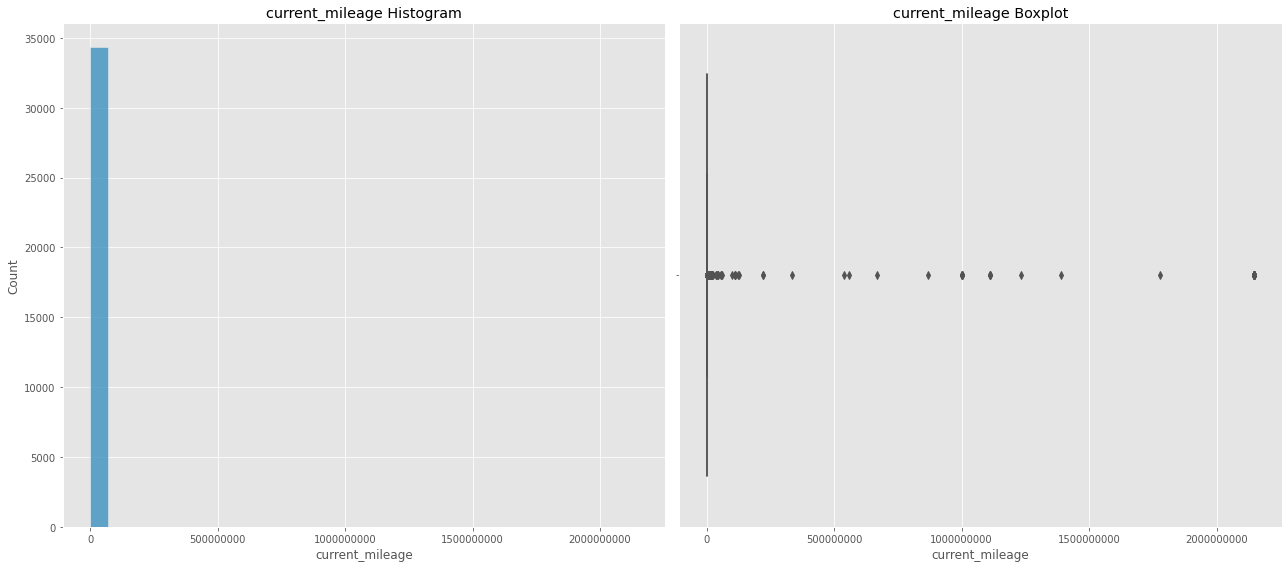

In [38]:
# Смотрю как выглядят распределения пробега, нужно избавится от выбросов за пределами усов
Hist_and_Box_Plots(train_data, 'current_mileage')

In [40]:
# Iteratively, I manually select the right coefficient by eye until the dots to the right of the outliers disappear
iqr_info_train_data, iqr_outliers_train_data, iqr_clean_train_data = outliers_iqr(train_data, 'current_mileage', log_scale=False, left=1.5, right=1.3)
iqr_info_train_data

'Выбросы: 1433 строк (4.17%).'

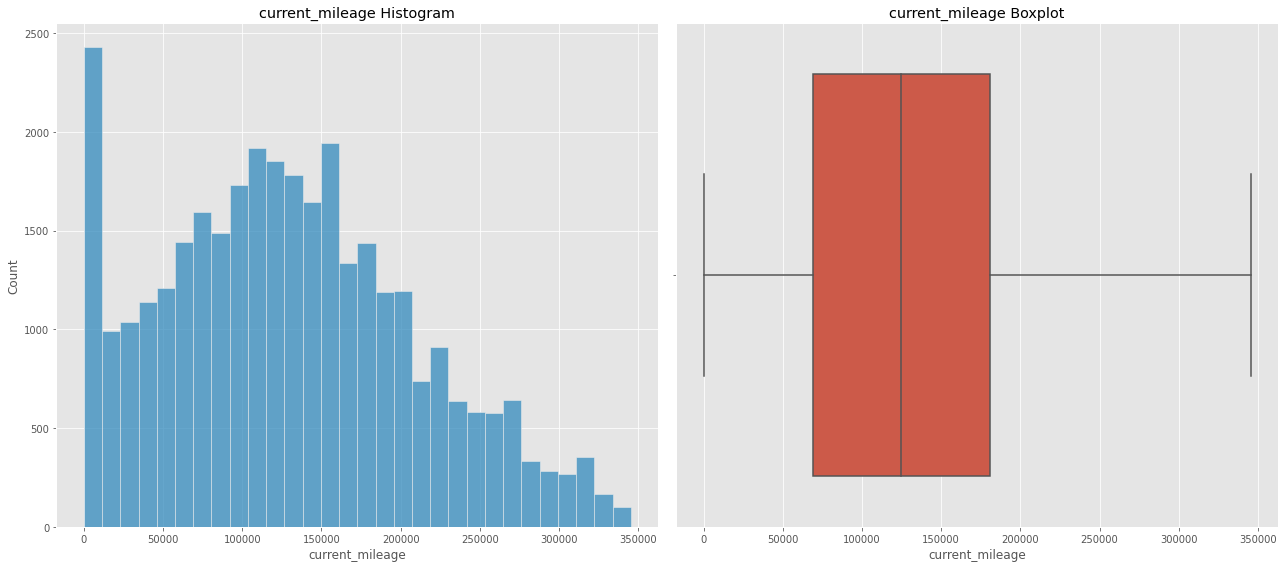

In [41]:
# Смотрю как выглядят распределения пробега после фильтрации
Hist_and_Box_Plots(iqr_clean_train_data, 'current_mileage')

In [42]:
# I save to the list the indexes of records that I consider to be outliers
outliers_list = list(iqr_outliers_train_data.index)

In [44]:
# Auxiliary function for marking an outlier attribute by index
def mark_by_index(df, ind_list):
    ind = df[0]
    
    if ind in ind_list:
        return True
    
    return False

In [45]:
# I decided not to delete outliers, but to mark them with a new feature in both datasets
train_data['outliers'] = train_data.apply(mark_by_index, axis=1, args=(outliers_list,))

In [46]:
# Iteratively, I manually select the right coefficient by eye until the dots to the right of the outliers disappear
iqr_info_test_data, iqr_outliers_test_data, iqr_clean_test_data = outliers_iqr(test_data, 'current_mileage', log_scale=False, left=1.5, right=1.3)
iqr_info_test_data

'Выбросы: 460 строк (4.30%).'

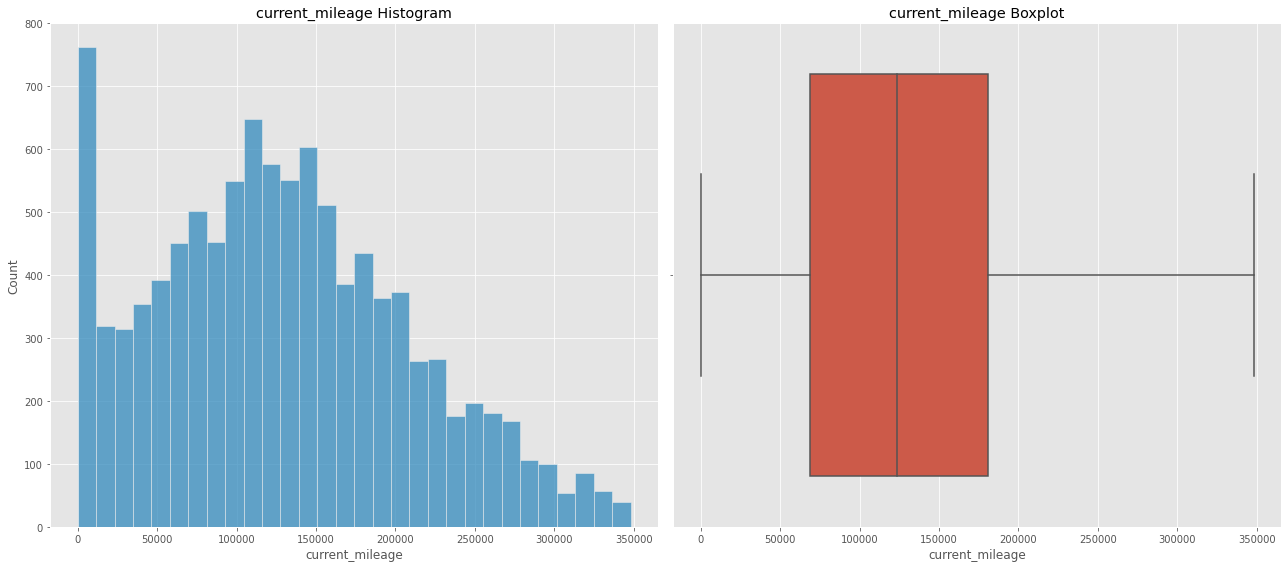

In [47]:
# # I'm looking at how mileage distributions look after filtering by the Tukey method
Hist_and_Box_Plots(iqr_clean_test_data, 'current_mileage')

In [48]:
# I save to the list the indexes of records that I consider to be outliers
outliers_list = list(iqr_outliers_test_data.index)

In [49]:
test_data['outliers'] = test_data.apply(mark_by_index, axis=1, args=(outliers_list,))

In [50]:
# I still remove huge runs from the training dataset
train_data = train_data[train_data['current_mileage'] < 500_000]

In [51]:
# Strange mileage values
# # When the same digit from 1 to 9 is repeated more than 5 times
# These are actually manually somehow filled in gaps. Just pressed a button with some number several times
re = r'[1]{5,}|[2]{5,}|[3]{5,}|[4]{5,}|[5]{5,}|[6]{5,}|[7]{5,}|[8]{5,}|[9]{5,}'

In [52]:
# Using a regular expression, I filter this data
train_strange_mileage = train_data[train_data['current_mileage'].astype('str').str.match(re)]
train_strange_mileage

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age,outliers
402,402,VOLKSWAGEN,Passat,Sedan,222222,Manual,4/5,Left wheel,Black,Black,NaN,1,For Sale,1700.00,22,False
404,404,FORD,Transit,Microbus,111111,Manual,2/3,Left wheel,Blue,Black,NaN,0,For Sale,3700.00,22,False
538,538,HONDA,FIT,Sedan,111111,Automatic,4/5,Left wheel,Grey,Black,NaN,0,For Sale,2800.00,13,False
609,609,DODGE,Caravan,Minivan,11111,Automatic,4/5,Left wheel,Blue,Black,NaN,0,For Sale,1300.00,23,False
610,610,SUBARU,Legacy,Sedan,222222,Tiptronic,4/5,Right-hand drive,Black,Black,NaN,0,For Sale,1900.00,18,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34041,34041,OPEL,Vectra,Sedan,222222,Manual,4/5,Left wheel,Carnelian red,Black,NaN,0,For Sale,1500.00,27,False
34447,34447,VOLKSWAGEN,Golf,Hatchback,111111,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,1900.00,21,False
34690,34690,MERCEDES-BENZ,C 300,Sedan,111111,Tiptronic,4/5,Left wheel,Black,Black,NaN,1,For Sale,6500.00,11,False
34763,34763,FORD,Transit,Goods wagon,11111,Manual,4/5,Left wheel,White,Beige,NaN,0,For Sale,3348.00,24,False


In [53]:
# I also mark such entries True in the sign of departures
ind_train_list = list(train_strange_mileage.index)
train_data['outliers'] = train_data.apply(mark_by_index, axis=1, args=(ind_train_list,),)

In [54]:
# The same for the test dataset
test_strange_mileage = test_data[test_data['current_mileage'].astype('str').str.match(re)]
test_strange_mileage

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,vehicle_age,outliers
34,35034,BMW,530 E60,Sedan,111111,Tiptronic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,17,False
127,35127,BMW,535,Sedan,111111,Tiptronic,4/5,Left wheel,Black,Black,NaN,1,For Sale,13,False
352,35352,FORD,Escape,Jeep,111111,Automatic,4/5,Left wheel,Silver,Grey,NaN,0,For Sale,13,False
525,35525,BMW,525,Sedan,7777787,Manual,4/5,Left wheel,Silver,Grey,NaN,1,For Sale,18,False
703,35703,LEXUS,RX 350,Sedan,99999,Automatic,4/5,Left wheel,Black,Black,NaN,1,For Rent,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10023,45023,HONDA,FIT,Sedan,111111,Automatic,4/5,Right-hand drive,Grey,Black,NaN,0,For Sale,17,False
10264,45264,VAZ,2107,Sedan,77777,Manual,4/5,Left wheel,White,Beige,NaN,0,For Sale,24,False
10537,45537,JEEP,Grand Cherokee,Jeep,111111,Tiptronic,4/5,Left wheel,Brown,White,NaN,0,For Sale,16,False
10548,45548,BMW,328,Sedan,111111,Manual,4/5,Left wheel,Green,Black,NaN,1,For Sale,21,False


In [55]:
# I also mark such entries True in the sign of departures
ind_test_list = list(test_strange_mileage.index)
test_data['outliers'] = test_data.apply(mark_by_index, axis=1, args=(ind_test_list,),)

In [56]:
# Target attribute analysis
# Zero price and 8 million price...
train_data['final_price'].describe()

count     33961.00
mean       5958.73
std       65170.21
min           0.00
25%        1500.00
50%        4000.00
75%        7039.00
max     8388607.00
Name: final_price, dtype: float64

In [ ]:
# Only 4 entries with a price above 200 th
train_data[train_data['final_price'] > 200_000]

In [57]:
#B 75 auto junk records, or just junk values
train_data[train_data['final_price'] <= 10]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age,outliers
603,603,NISSAN,Note,Hatchback,117000,Automatic,4/5,Right-hand drive,Red,Black,NaN,1,For Sale,10.00,16,False
1283,1283,TOYOTA,Prius,Hatchback,111111,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,6.00,13,True
1941,1941,LEXUS,CT 200h,Hatchback,0,Automatic,4/5,Left wheel,Grey,NaN,JTHKD5BH4F2213221,1,For Sale,10.00,6,False
2526,2526,NISSAN,X-Terra,Jeep,323200,Automatic,4/5,Left wheel,Black,Black,NaN,0,For Sale,1.00,17,False
2785,2785,MERCEDES-BENZ,G 55 AMG,Jeep,1212,Manual,>5,Left wheel,Purple,Black,NaN,1,For Sale,1.00,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31675,31675,VOLKSWAGEN,Jetta,Sedan,41000,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,1.00,5,False
33185,33185,MERCEDES-BENZ,C 220,Sedan,20600,Manual,4/5,Left wheel,Black,Black,NaN,0,For Sale,1.00,23,False
33318,33318,HONDA,FIT,Hatchback,123000,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,10.00,13,False
33517,33517,OPEL,Astra,Hatchback,147000,Manual,4/5,Left wheel,Blue,Black,NaN,1,For Sale,1.00,27,False


In [58]:
# Removing all this from the training sample
train_data = train_data[(train_data['final_price'] > 10) & (train_data['final_price'] <= 200_000)]

In [59]:
# Duplicates
# Duplicate search columns
cols = list(test_data.columns)[1:]
cols.remove('outliers')
cols.remove('deal_type')
cols

['vehicle_manufacturer',
 'vehicle_model',
 'vehicle_category',
 'current_mileage',
 'vehicle_gearbox_type',
 'doors_cnt',
 'wheels',
 'vehicle_color',
 'vehicle_interior_color',
 'car_vin',
 'car_leather_interior',
 'vehicle_age']

In [60]:
# Creating a warning sign that the record is a duplicate
train_data['duplicate'] = train_data.duplicated(subset=cols)
test_data['duplicate'] = test_data.duplicated(subset=cols)

In [61]:
# I translate the target attribute to the whole type, the accuracy is excessive, and the model will be easier to work with
train_data[TARGET_NAME] = train_data[TARGET_NAME].astype('int')

In [62]:
%%time

def create_expert_feats(data):
    pass

create_expert_feats(train_data)
create_expert_feats(test_data)

CPU times: user 29 µs, sys: 10 µs, total: 39 µs
Wall time: 43.6 µs


### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [63]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (27105, 17), te_data = (6777, 17)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age,outliers,duplicate
2649,2649,TOYOTA,Camry,Sedan,190549,Automatic,4/5,Left wheel,Black,Black,4T4BF1FK2DR307417,1,For Sale,1600,8,False,True
11369,11369,CHEVROLET,Cruze,Sedan,150000,Automatic,4/5,Left wheel,Grey,Black,NaN,1,For Sale,3687,8,False,False
22322,22322,HYUNDAI,Santa FE,Jeep,161052,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,12031,5,False,False
12320,12320,RENAULT,Logan,Hatchback,189000,Manual,4/5,Left wheel,White,Black,NaN,1,For Sale,4500,14,False,False
8622,8622,LEXUS,CT 200h,Hatchback,146733,Automatic,4/5,Left wheel,NaN,NaN,JTHKD5BH3C2093052,1,For Sale,300,9,False,False


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [64]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [65]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID', 'deal_type'] # I don't use the deal_type feature to build a model
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [68]:
# In the article I saw from the developers that this class works better than TabularAutoML
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [69]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[13:18:53] Start automl utilizator with listed constraints:
[13:18:53] - time: 900.00 seconds
[13:18:53] - CPU: 4 cores
[13:18:53] - memory: 16 GB

[13:18:53] If one preset completes earlier, next preset configuration will be started

[13:18:53] ==================================================
[13:18:53] Start 0 automl preset configuration:
[13:18:53] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[13:18:53] Stdout logging level is INFO.
[13:18:53] Task: reg

[13:18:53] Start automl preset with listed constraints:
[13:18:53] - time: 900.00 seconds
[13:18:53] - CPU: 4 cores
[13:18:53] - memory: 16 GB

[13:18:53] Train data shape: (27105, 17)

[13:19:01] Layer 1 train process start. Time left 892.28 secs
[13:19:03] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:19:23] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2501.9540825842932
[13:19:23] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting

In [70]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	1.00000 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 





# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [71]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[ 1145.7656 ],
       [10708.774  ],
       [  293.36548],
       ...,
       [ 6542.941  ],
       [ 7713.897  ],
       [ 4733.264  ]], dtype=float32)
Shape = (6777, 1)
CPU times: user 10 s, sys: 15.9 ms, total: 10 s
Wall time: 2.76 s


In [72]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

TRAIN out-of-fold score: 1611.2440443013475
HOLDOUT score: 1542.1170286340173


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In [85]:
%%time

# Fast feature importances calculation
# fast_fi = automl.get_feature_scores('fast')
# fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


In [74]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

CPU times: user 2min 27s, sys: 63.8 ms, total: 2min 27s
Wall time: 40 s


<AxesSubplot:xlabel='Feature'>

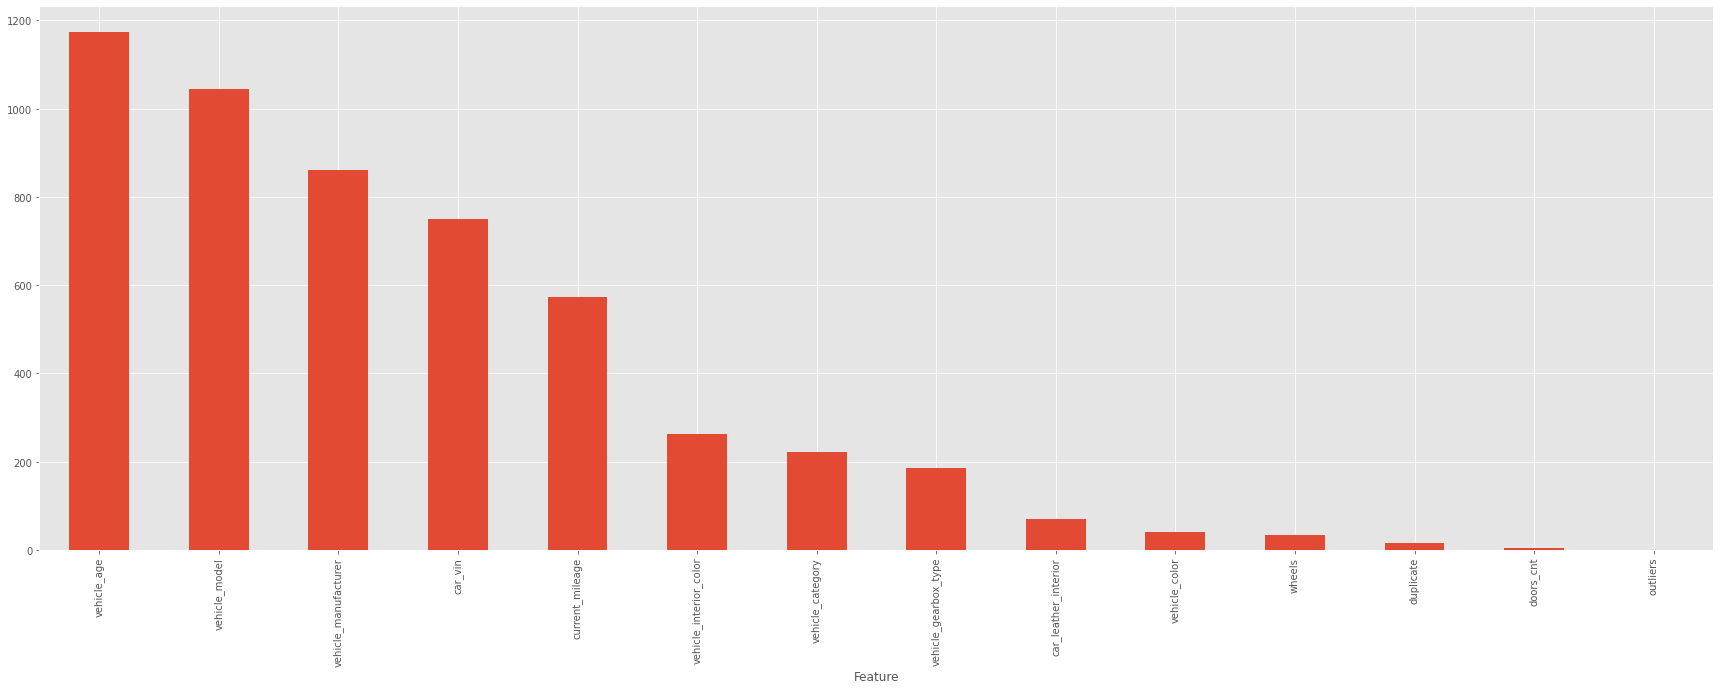

In [75]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

In [76]:
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [77]:
%%time
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1)

[13:30:25] Start automl utilizator with listed constraints:
[13:30:25] - time: 900.00 seconds
[13:30:25] - CPU: 4 cores
[13:30:25] - memory: 16 GB

[13:30:25] If one preset completes earlier, next preset configuration will be started

[13:30:25] ==================================================
[13:30:25] Start 0 automl preset configuration:
[13:30:25] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[13:30:25] Stdout logging level is INFO.
[13:30:25] Task: reg

[13:30:25] Start automl preset with listed constraints:
[13:30:25] - time: 900.00 seconds
[13:30:25] - CPU: 4 cores
[13:30:25] - memory: 16 GB

[13:30:25] Train data shape: (33882, 17)

[13:30:31] Layer 1 train process start. Time left 893.94 secs
[13:30:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:30:53] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2486.5077366802743
[13:30:53] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting

In [78]:
print(f'FULL TRAIN score: {mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')

FULL TRAIN score: 1576.1573312856794


In [79]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2691.4883],
       [ 5788.6626],
       [ 4082.7468],
       ...,
       [17611.4   ],
       [ 4761.9067],
       [ 6530.189 ]], dtype=float32)
Shape = (10697, 1)


In [80]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission

,row_ID,final_price
0,35000,2691.49
1,35001,5788.66
2,35002,4082.75
3,35003,737.37
4,35004,5024.94
...,...,...
10692,45692,921.56
10693,45693,1611.85
10694,45694,17611.40
10695,45695,4761.91


In [81]:
# # I process rental cars manually, change all values to the median rental cost of $16
submission.at[rent_cars_index_list, 'final_price'] = 16

In [82]:
# Manual edit of a completely null entry
submission.at[index_to_set_zero, 'final_price'] = 0

In [83]:
submission.to_csv('submission.csv', index = False)

In [ ]:
# test_pred = automl.predict(test_data)
# print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

In [ ]:
# submission[TARGET_NAME] = test_pred.data[:, 0]
# submission.to_csv('lightautoml_tabularautoml.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [ ]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)